# Inferential Statistics III - Bayesian

## Introduction

In the last two subunits, you've encountered two schools for performing inference from samples. The Frequentist school calls upon a body of theory established over the past couple of centuries or so. Under certain assumptions and conditions, this allows us to calculate what we would expect to see if an experiment were to be repeated again and again and again. The expected value of the average of a sample is one such statistic we can calculate a result for, even if the originating distribution is far from normal. The bootstrap school, on the other hand, literally does (virtually) run that experiment again and again and again and empirically observes the multitude of outcomes. It then empirically calculates a statistic of interest. While this can be for exactly the same statistics that frequentism calculates (e.g. the mean of a sample) this empirical approach can also perform inference on statistics that do not have well known sampling distributions. Because of the requirement to repeat many, many redraws (with replacement) from the sample, this approach only became feasible with modern computing power.

And thus we come to the Bayesian school of inference. Here we frame our probabilities not so much in terms of "how many times would I expect this event to occur if the experiment were to be rerun many times" but rather in terms of "what is my belief in the likelihood of this event occurring?" In a Bayesian probabilistic programming context, we can build models for systems and then let the data tell us how likely certain values for our model parameters are. This can be a very useful way to incorporate prior knowledge and deal with limited data. It can just be more than a _little_ fiddly to produce a good model!

## Medical charge data set

For the final mini-project of the stats unit, you'll once again return tot he medical charge data you've used for the other mini-projects. Previously, we considered whether we believed that the actual average(non-insured) charge had fallen below a certain threshold.

The hospital is now reviewing its financial resiliency plan, which requires a model for revenue under a range of conditions that include the number of patients treated. Its current model is based on a confidence interval for the mean, and scaling that by different numbers of patients for each scenario. This approach has a number of limitations, most acutely the breakdown of the central limit theorem for low patient volumes; the current model does not do a good job of reflecting the variability in revenue you would see as the number of cases drops. A bootstrap approach would return samples of the same size as the original. Taking subsamples would restrict the sampling to the values already present in the original sample and would not do a good job of representing the actual variability you might see. What is needed is a better model of individual charges.

So the problem here is that we want to model the distribution of individual charges and _we also really want to be able to capture our uncertainty about that distribution_ so we can better capture the range of values we might see. This naturally leads us to a powerful, probabilistic approach — we'll use the pymc3 library to perform Bayesian inference.

### Loading the data and performing an initial view

In [22]:
#  Import necessary packages
from IPython.core.pylabtools import figsize
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
import seaborn as sns
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

In [23]:
# set up access to files and establish default figure size for charts
figsize(12,7)
path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'
file = 'insurance2.csv'
filef = path + file
medical = pd.read_csv(filef)

In [24]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [25]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

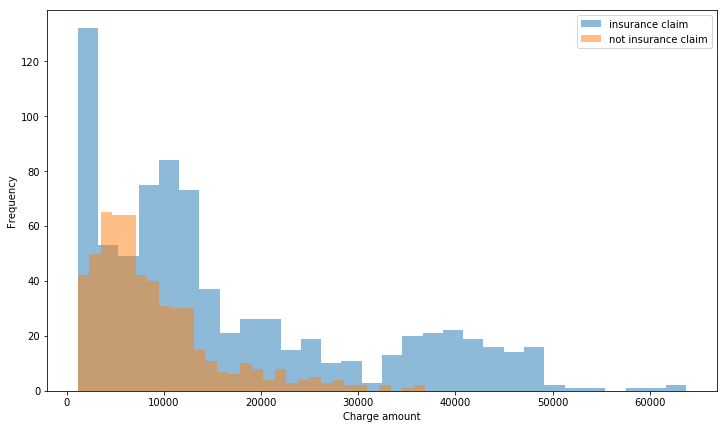

In [26]:
# chart the two together (insured and non insured)
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()
plt.show()

We may suspect from the above that there is some sort of exponential-like distribution at play here. The charges that were not insurance claims seem most like this. The insurance claim charges may possibly be multimodal. The gamma distribution may be applicable and we could test this for the distribution of charges that weren't insurance claims first. Developing our new method for the easiest looking case first is a common and sound approach that can demonstrate a minimum viable solution/product and get, or keep, stakeholders on board.

### Initial parameter estimation

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made as described [here](https://wiki.analytica.com/index.php?title=Gamma_distribution).

In [27]:
# calculate parameters for pymc3 MCMC model
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
rate_est = 1/beta_est
print(alpha_est, beta_est, rate_est)

1.8759059725250857 4702.486170152821 0.00021265346963636093


### Initial simulation

Let's draw the same number of random variates from this distribution and compare to our observed data.

In [28]:
# generate gamma distribution with alpha and beta initial estimates of parameters for non insured
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

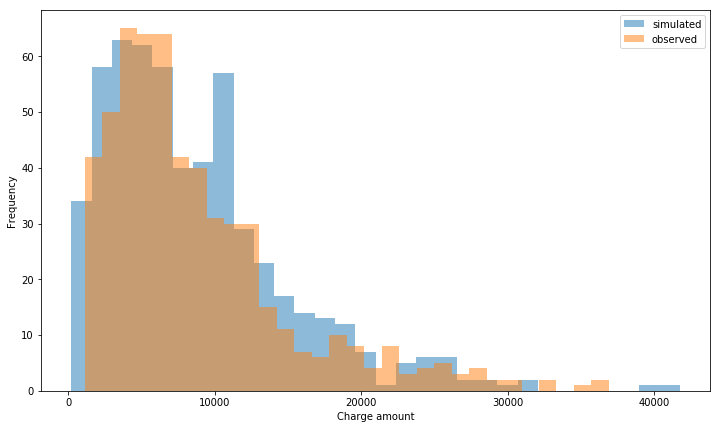

In [29]:
# chart gamma distibution against non insured data.
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()
plt.show()

Well it doesn't look too bad! We're not a million miles off. But can we do better? We have a plausible form for the distribution of charge amounts and potential values for that distribution's parameters so we can already draw random variates from that distribution to perform simulations. But we don't know if we have a _best_ estimate for the population parameters, and we also only have a single estimate each for $\alpha$ and $\beta$; we aren't capturing our uncertainty in their values. Can we take a Bayesian inference approach to estimate the parameters?

### Creating a PyMC3 model

In [30]:
#
## PyMC3 Gamma seems to use rate = 1/beta
## Initial parameter estimates we'll use below

# 10000 samples for model
N = 10000


__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then, before that, you need to create those stochastic variables using `pm.Exponential` and the correct parameters.

__A:__

In [31]:
# model definition form MCMC
with pm.Model() as model:
    alpha_ = pm.Exponential("alpha_", alpha_est)
    rate_ = pm.Exponential("rate_", rate_est)
    obs = pm.Gamma("obs", alpha_, rate_, observed=no_insurance)
    step = pm.Metropolis()
    trace = pm.sample(N,step=step,cores=1)
# print some initial information on trace file
print('Variable Names in Trace: ')
print(trace.varnames)
print('\n')
print('Summary Statistics from Trace: ')
print(pm.summary(trace))
print('\n')

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rate_]
>Metropolis: [alpha_]
100%|██████████| 10500/10500 [00:17<00:00, 599.67it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Variable Names in Trace: 
['alpha__log__', 'rate__log__', 'alpha_', 'rate_']


Summary Statistics from Trace: 
            mean        sd  mc_error   hpd_2.5  hpd_97.5      n_eff      Rhat
alpha_  2.196669  0.126431  0.009245  1.985230  2.487988  99.041053  1.000317
rate_   0.000249  0.000016  0.000001  0.000218  0.000282  94.733684  1.000341




If you get a warning about acceptance probability not matching the target, and that it's around 0.88 when it should be close to 0.8, don't worry. We encourage you to read up on this and see if you can adjust the parameters and/or arguments to pm.sample, but if your model runs without any additional warnings or errors then you should be doing great!

__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

__A:__



alpha distplot with 2.5 and 97.5 percentiles...




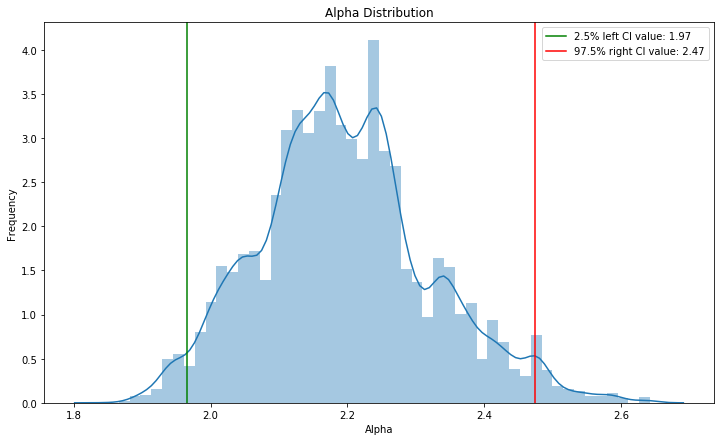



rate distplot with 2.5 and 97.5 percentiles...




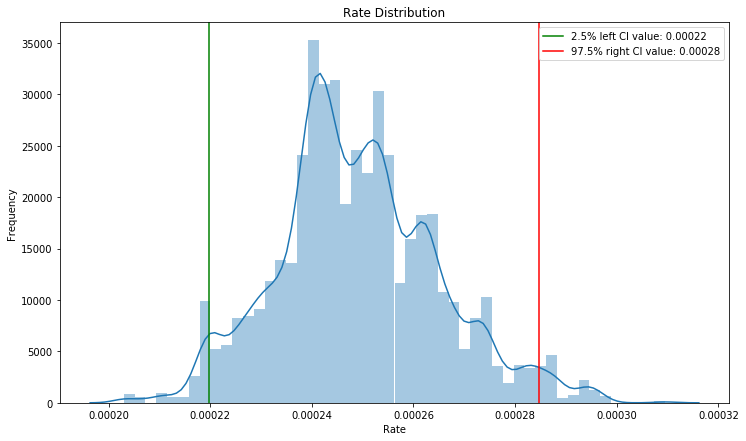

In [32]:

# extract chains from trace
trace_alpha = trace['alpha_']
trace_rate  = trace['rate_']

# print some plots on trace file with 95% CI two tailed
print('\n')
print('alpha distplot with 2.5 and 97.5 percentiles...')
print('\n')

p_vals_alpha = np.percentile(trace_alpha,[2.5, 97.5])
label0 = '2.5% left CI value: '
label0 = label0 + '%1.2f' % p_vals_alpha[0]
label1 = '97.5% right CI value: '
label1 = label1 + '%1.2f' % p_vals_alpha[1]
_ = sns.distplot(trace_alpha)
_ = plt.title('Alpha Distribution')
_ = plt.xlabel('Alpha')
_ = plt.ylabel('Frequency')
_ = plt.axvline(p_vals_alpha[0],label=label0,color='green')
_ = plt.axvline(p_vals_alpha[1],label=label1,color='red')
_ = plt.legend()
plt.show()

print('\n')
print('rate distplot with 2.5 and 97.5 percentiles...')
print('\n')

p_vals_rate = np.percentile(trace_rate,[2.5, 97.5])
label0 = '2.5% left CI value: '
label0 = label0 + '%1.5f' % p_vals_rate[0]
label1 = '97.5% right CI value: '
label1 = label1 + '%1.5f' % p_vals_rate[1]
_ = sns.distplot(trace_rate)
_ = plt.title('Rate Distribution')
_ = plt.xlabel('Rate')
_ = plt.ylabel('Frequency')
_ = plt.axvline(p_vals_rate[0],label=label0,color='green')
_ = plt.axvline(p_vals_rate[1],label=label1,color='red')
_ = plt.legend()
plt.show()

traceplot, plot_posterior and autocorrplot...


traceplot...




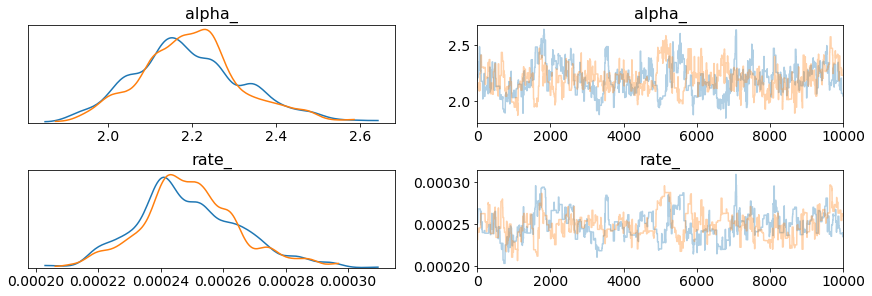



plot_posterior...




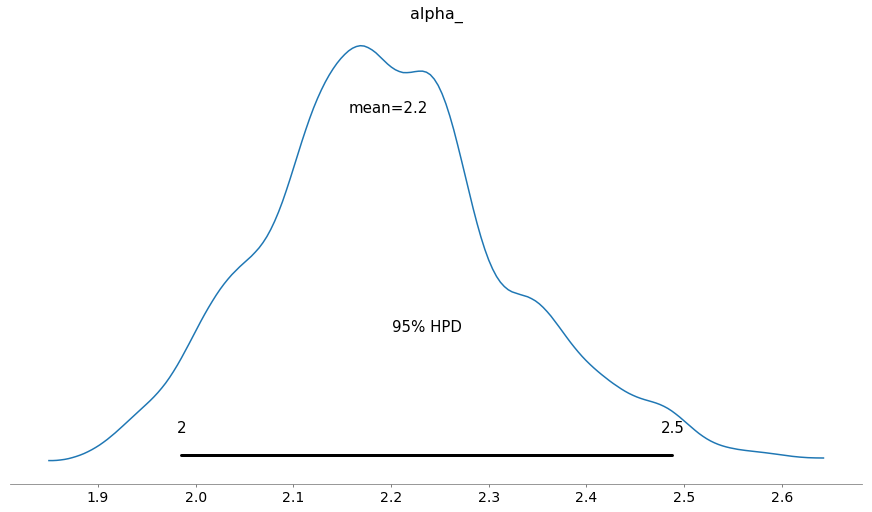

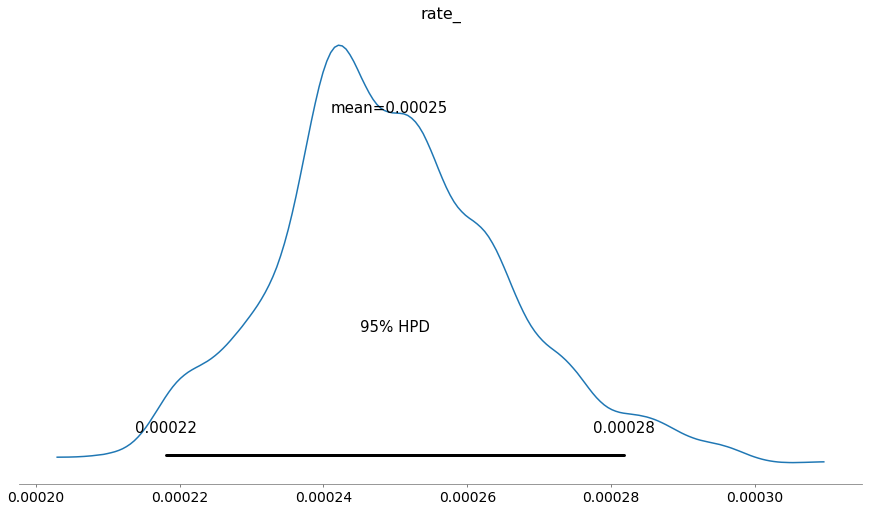



autocorrplot...




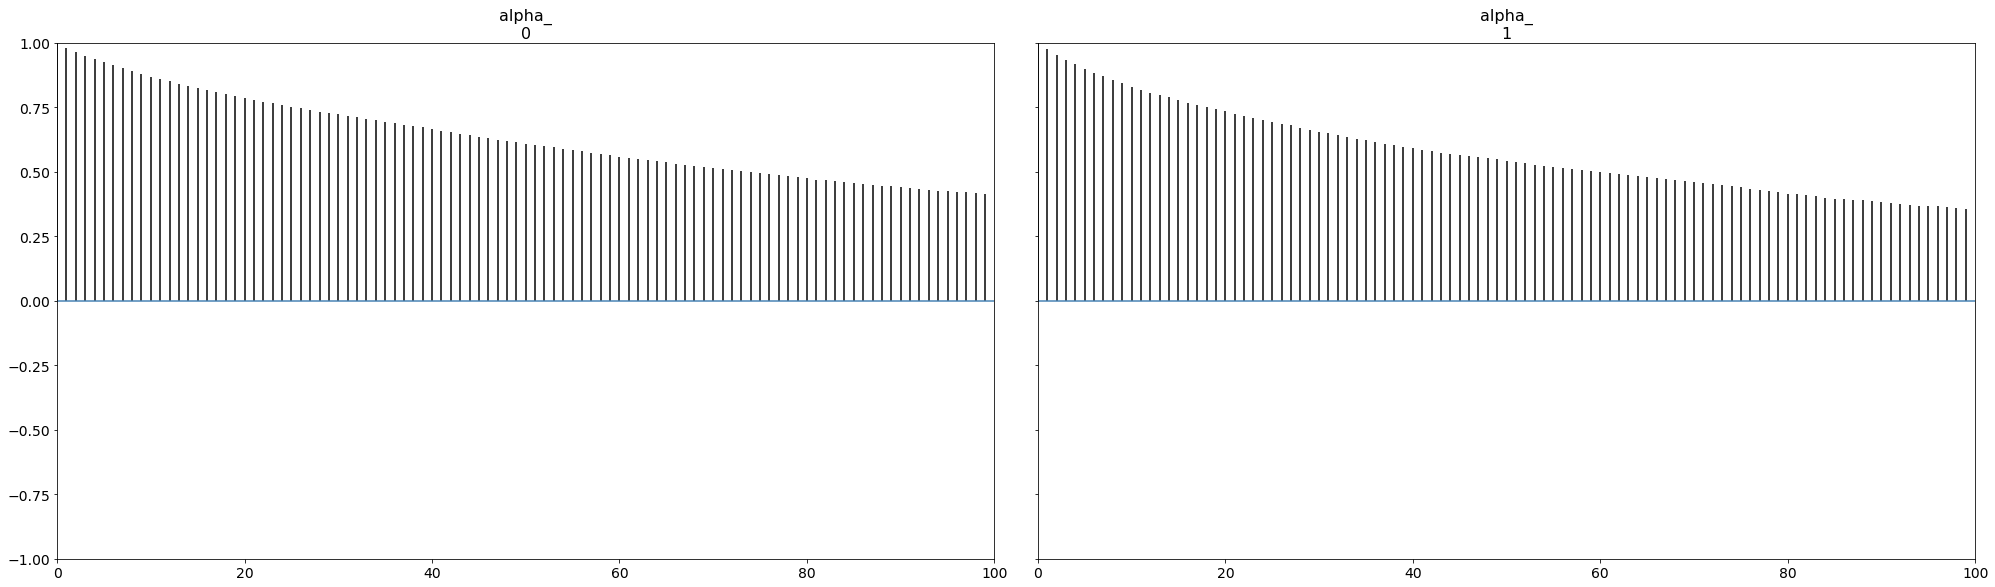

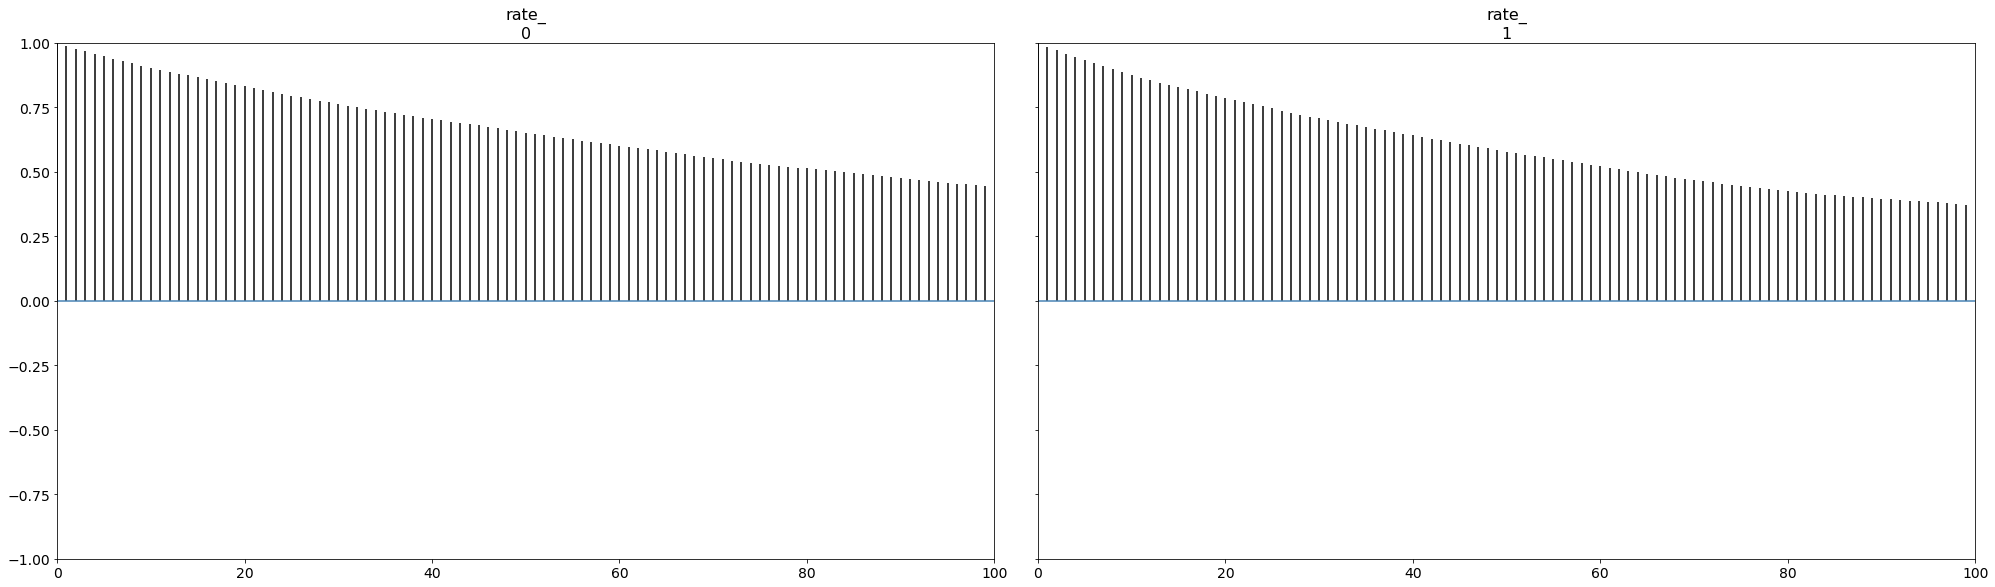

In [33]:
# print some of the builtin plots to pymc3
print('traceplot, plot_posterior and autocorrplot...')
print('\n')
print('traceplot...')
print('\n')
pm.plots.traceplot(trace,['alpha_', 'rate_'])
plt.show()
print('\n')
print('plot_posterior...')
print('\n')
pm.plots.plot_posterior(trace,['alpha_'],credible_interval=.95)
pm.plots.plot_posterior(trace,['rate_'],credible_interval=.95)
plt.show()
print('\n')
print('autocorrplot...')
print('\n')
pm.plots.autocorrplot(trace,['alpha_'])
pm.plots.autocorrplot(trace,['rate_'])
plt.show()

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

Some Diagnostics as to Convergence

__A:__

Effective Sample Sizes :  {'alpha_': 99.0410528291091, 'rate_': 94.73368363340214}
Gelman Rubin Test for Convergence : {'alpha_': 1.000316543344776, 'rate_': 1.000340539169563}


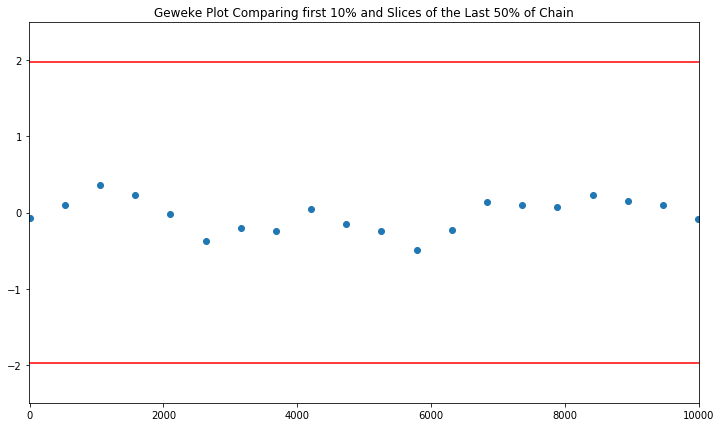

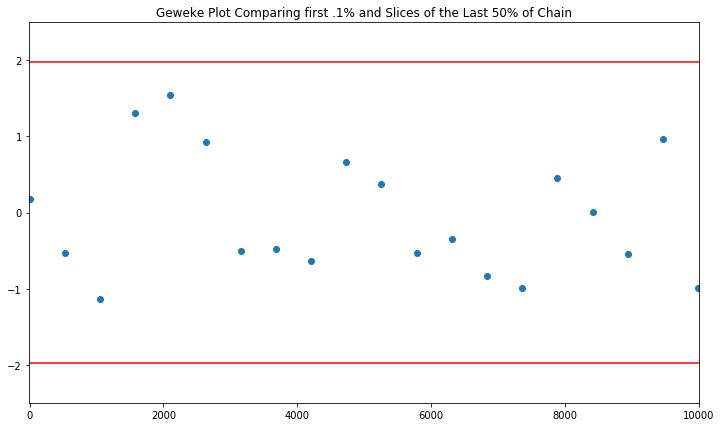

In [34]:
# effective sample sizes for alpha and rate
print('Effective Sample Sizes : ', pm.effective_n(trace))

# run gelman rubin test.  should be close to 1
print('Gelman Rubin Test for Convergence :', pm.gelman_rubin(trace))

# use geweke function which is a time-series approach that compares the mean and 
# variance of segments from the beginning and end of a single chain.
# from work done by John Geweke

# use geweke to take a look at convergence
# by default it take beginning 10% and 50% from end of chain
# not strong evidence that the means are the same which implies convergence
# should have abs value less than one at convergence.  this is a visual.
gw_plot1 = pm.geweke(trace['alpha_'])
plt.scatter(gw_plot1[:,0],gw_plot1[:,1])
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
plt.title('Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain')
plt.xlim(-10,N)
plt.show()

# by the first .1 % of chain and then the last 50% of chain.  20 subchains is default
# should see some variation due to initial burn in of model
# initial first .1% shows a lot of variance due to initial model rampup
gw_plot1 = pm.geweke(trace['alpha_'],.001,.5,20)

plt.scatter(gw_plot1[:,0],gw_plot1[:,1])
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
plt.title('Geweke Plot Comparing first .1% and Slices of the Last 50% of Chain')
plt.xlim(-10,N)
plt.show()

__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

__A:__

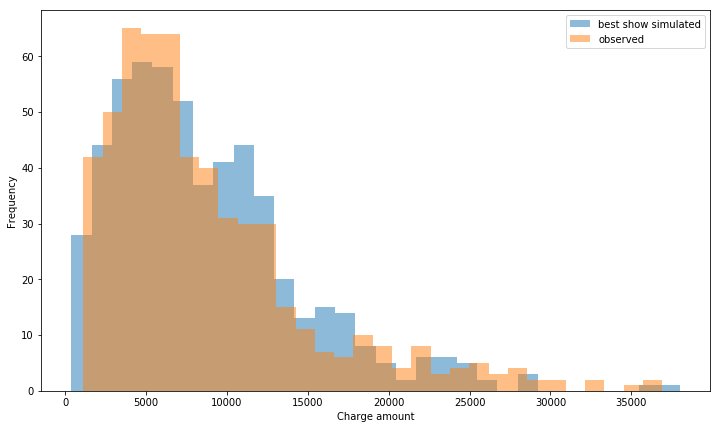

In [35]:
# simulate with means of new parameters generated in pymc3 model using MCMC
seed(47)
best_show_simulated = gamma(2.2, scale=1/.00025).rvs(n_no_ins)

# plot with new parameters
_ = plt.hist(best_show_simulated, bins=30, alpha=0.5, label='best show simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()
plt.show()


## Summary

In this exercise, we have postulated a distribution to describe the individual charge amounts for non-insured cases. This distribution has two required parameters, which we do not know, but we used PyMC3 to perform Bayesian inference to find our level of "belief" in a range of values for them. We then used the average parameter values to create one simulated data set of the same size as the original, but the distribution of our posteriors for these parameters will allow us to perform simulations of any sample size we desire and for a range of scenarios of different $\alpha$ and $\beta$. This could be a powerful tool to model different financial conditions for the hospital. 

Well done making it through this tricky subject. Starting think Bayesian _and_ starting to get to grips with something like PyMC3 is no easy task. As a data scientist, the most important thing is to be aware that this statistical approach exists, though you may not actually use this approach as much as you use the other approaches you've learned about. Still, we encourage you to think of ways that this approach could apply to the work that you do in this course and throughout your career.  